<a href="https://colab.research.google.com/github/pinballsurgeon/deluxo_adjacency/blob/main/tf_quantum_svgCircuit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install cirq

!pip install tensorflow_quantum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.5 MB 16.1 MB/s 
     |████████████████████████████████| 1.6 MB 35.3 MB/s 
     |████████████████████████████████| 6.1 MB 6.1 MB/s 
     |████████████████████████████████| 576 kB 46.2 MB/s 
     |████████████████████████████████| 100 kB 6.2 MB/s 
     |████████████████████████████████| 90 kB 10.3 MB/s 
     |████████████████████████████████| 90 kB 8.9 MB/s 
     |████████████████████████████████| 641 kB 56.1 MB/s 
     |████████████████████████████████| 541 kB 52.2 MB/s 
     |████████████████████████████████| 541 kB 60.0 MB/s 
     |████████████████████████████████| 437 kB 60.3 MB/s 
     |████████████████████████████████| 93 kB 2.0 MB/s 
     |████████████████████████████████| 93 kB 1.6 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 
     |████████████████████████████████| 93 

In [20]:
import cirq
import sympy
import tensorflow
import numpy

%matplotlib inline
import matplotlib.pyplot

from cirq.contrib.svg import SVGCircuit

import tensorflow_quantum

In [3]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


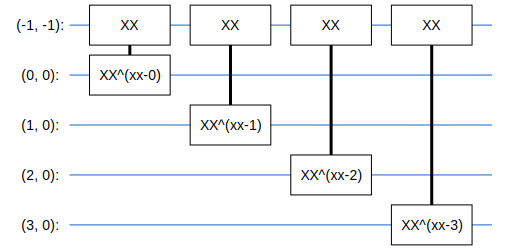

In [4]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [5]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [6]:
model_circuit, model_readout = create_quantum_model()

In [10]:
# Build the Keras model.
model = tensorflow.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tensorflow.keras.layers.Input(shape=(), dtype=tensorflow.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tensorflow_quantum.layers.PQC(model_circuit, model_readout),
])

In [15]:
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., numpy.newaxis]/255.0, x_test[..., numpy.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [16]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [17]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


True


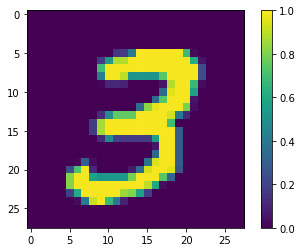

In [21]:
print(y_train[0])

matplotlib.pyplot.imshow(x_train[0, :, :, 0])
matplotlib.pyplot.colorbar()

In [23]:
x_train_small = tensorflow.image.resize(x_train, (4,4)).numpy()
x_test_small = tensorflow.image.resize(x_test, (4,4)).numpy()

In [24]:
x_train_nocon, y_train_nocon = x_train_small, y_train

In [25]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

In [28]:
THRESHOLD = 0.5

x_train_bin = numpy.array(x_train_nocon > THRESHOLD, dtype=numpy.float32)
x_test_bin = numpy.array(x_test_small > THRESHOLD, dtype=numpy.float32)

In [30]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = numpy.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

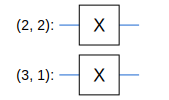

In [31]:
SVGCircuit(x_train_circ[0])

In [33]:
bin_img = x_train_bin[0,:,:,0]
indices = numpy.array(numpy.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

In [34]:
x_train_tfcirc = tensorflow_quantum.convert_to_tensor(x_train_circ)
x_test_tfcirc = tensorflow_quantum.convert_to_tensor(x_test_circ)